In [30]:
#!/usr/bin/env/python
from Bio import SeqIO
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
with open("Salmonella_enterica.txt", "r") as f1:
    record = SeqIO.read(f1, "fasta") 
    n = len(record.seq)
    dna_seq = record.seq
    GC_content = {
        'G':[0 for x in range(n)],
        'C':[0 for x in range(n)],
        "G-C": [0 for x in range(n)]
    }
    for i in range(n):
        GC_content['G'][i] = GC_content['G'][i-1] + 1 if (record.seq[i] == "G") else GC_content['G'][i-1] 
        GC_content['C'][i] = GC_content['C'][i-1] + 1 if (record.seq[i] == "C") else GC_content['C'][i-1] 
        GC_content["G-C"][i] = GC_content['G'][i] - GC_content['C'][i]
min_G_C = min(GC_content["G-C"])
lowest_points = []
for i in range(n):
    if (GC_content["G-C"][i] == min_G_C):
        lowest_points.append(i)


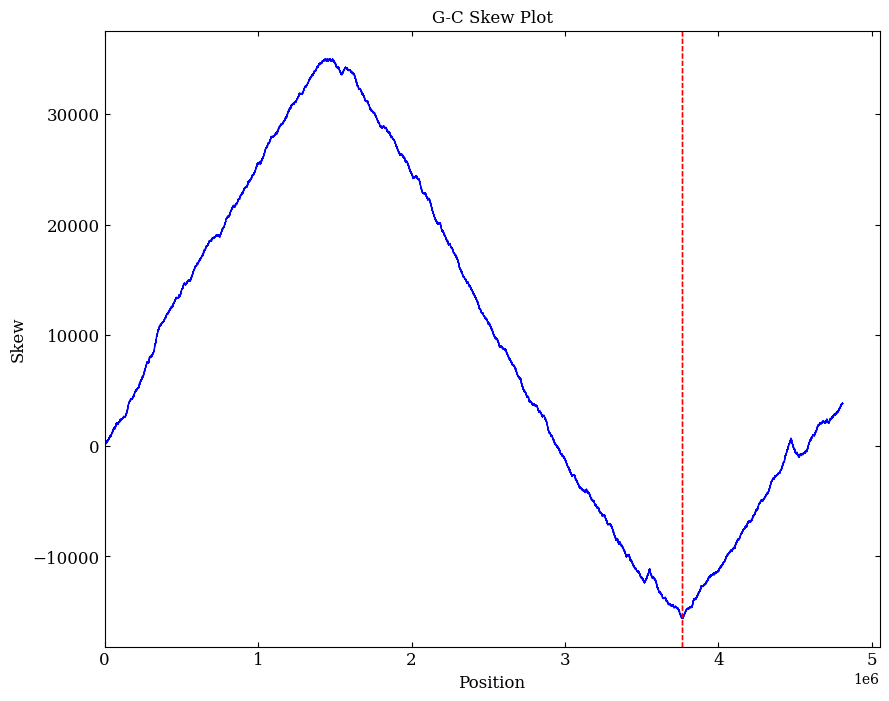

In [152]:
plt.rcParams['font.family'] = 'serif'
plt.figure(figsize=(10,8))
pos = [x for x in range(n)]
plt.plot(pos, 
         GC_content["G-C"],
         color='blue',
         linewidth=1)
plt.title("G-C Skew Plot")
plt.xlim(left=0)
plt.xlabel("Position", fontsize=12)
plt.ylabel("Skew", fontsize=12)
plt.tick_params(direction='in', top=True, right=True, which='both', labelsize=12)
for p in lowest_points:
    plt.axvline(x=p,
                color="red",
                linestyle="--",
                linewidth=1,
                label="min-skew")
plt.savefig(f"G-C Skew Plot", dpi = 300)
plt.show()


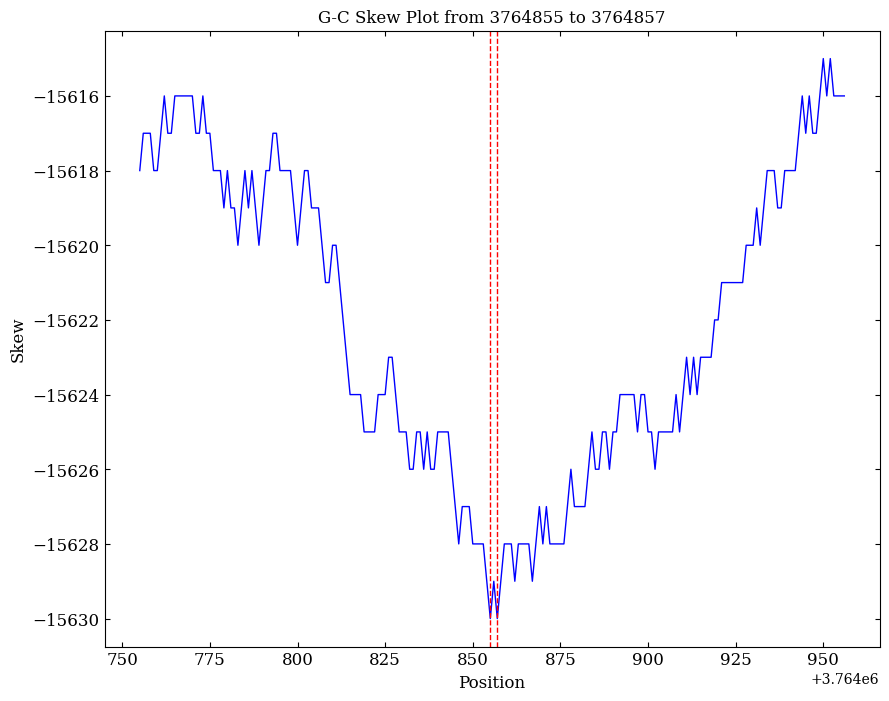

In [151]:

plt.figure(figsize=(10,8))
pos = [x for x in range(lowest_points[0]-100, lowest_points[-1]+100)]
plt.plot(pos, 
         GC_content["G-C"][lowest_points[0]-100:lowest_points[-1]+100],
         color='blue',
         linewidth=1)
#plt.xlim(left=0)
plt.title(f"G-C Skew Plot from {lowest_points[0]} to {lowest_points[-1]}")
plt.xlabel("Position", fontsize=12)
plt.ylabel("Skew", fontsize=12)
plt.tick_params(direction='in', top=True, right=True, which='both', labelsize=12)
for p in lowest_points:
    plt.axvline(x=p,
                color="red",
                linestyle="--",
                linewidth=1,
                label="min-skew")
plt.savefig(f"G-C Skew Plot from {lowest_points[0]} to {lowest_points[-1]}", dpi = 300)
plt.show()


In [76]:

def hamming(s1, s2):
    cnt = 0
    for i in range(len(s1)):
        if (s1[i] != s2[i]):
            cnt += 1
    return cnt

def revcomp(seq):
    return str(seq).translate(str.maketrans("ACGTN", "TGCAN"))[::-1]

def neighbors(s1, d):
    mismatches = {}
    nu = ["A", "C", "G", "T"]
    mismatches[0] = [s1]
    patterns = set()
    patterns.add(s1)
    for i in range(1, d + 1):
        mismatches[i] = []
        for father_string in mismatches[i-1]:
            for k in range(len(s1)):
                for x in nu:
                    if (father_string[k] != x):
                        tmp = list(father_string)
                        tmp[k] = x
                        pattern = "".join(map(str,tmp))
                        mismatches[i].append(pattern)
                        patterns.add(pattern)
    return patterns


In [120]:
start = int(lowest_points[0])
end = int(lowest_points[-1]) + 600
seq_window = dna_seq[start:end+1]
k_mer = []
k = 9 #length-kmer
d = 1 #allowed mismatches
window_sz = end - start + 1 #length window
for i in range (window_sz - k + 1):
    k_mer.append(seq_window[i:i+k])
mp = {}
for i in range(window_sz - k + 1):
    neighborhood = neighbors(k_mer[i],d)
    #print(neighborhood)
    for j in neighborhood:
        c = min(j, revcomp(j))   
        #mp[j] = mp.get(j,0) + 1
        mp[c] = mp.get(c, 0) + 1
max1 = max(mp.values())
pattern = ""
for key,val in mp.items():
    if (val == max1 and val > 2):
        pattern = key
print(pattern, max1)

CCAGGATCC 6


In [150]:
i = 0
print(f"Pattern: {pattern}")
print(f"Reverse pattern: {revcomp(pattern)}")
print(f"""Red text indicates the consensus pattern, while green text highlights the 
mismatch (mutation). Since each k-mer (length 9) allows only one mismatch, 
observing two green mutations within a single window suggests an overlap: 
one mutation likely belongs to the current k-mer, while the other belongs 
to an adjacent, overlapping k-mer.\n""")
RED = '\033[91m'
BLUE = '\033[94m' 
GREEN = '\033[92m'
RESET = '\033[0m'
seq_window = str(seq_window)  
highlight = [0] * (window_sz)  
for i in range(window_sz - k + 1):
    seq1 = revcomp(seq_window[i:i+k])
    seq2 = seq_window[i:i+k]
    flag1 = (hamming(seq1, pattern) <= d)
    flag2 = (hamming(seq2, pattern) <= d)

    if (flag1 or flag2):
       ref = seq1 if (flag1) else seq2
       const = highlight[i] + 1
       highlight[i] += 1
       for j in range(i, i+k):
            highlight[j] = const
            if (ref[j-i] != pattern[j-i]):
                highlight[j] -=99

for i, base in enumerate(seq_window):
    if highlight[i] == 1:
        print(f"{RED}{base}{RESET}", end="")
    elif highlight[i] == 2:
        print(f"{BLUE}{base}{RESET}", end="")
    elif highlight[i] < 0:
        print(f"{GREEN}{base}{RESET}", end="")
    else:
        print(base.lower(), end="")
    if (i+1) % 53 == 0:
        print()
    

Pattern: CCAGGATCC
Reverse pattern: GGATCCTGG
Red text indicates the consensus pattern, while green text highlights the 
mismatch (mutation). Since each k-mer (length 9) allows only one mismatch, 
observing two green mutations within a single window suggests an overlap: 
one mutation likely belongs to the current k-mer, while the other belongs 
to an adjacent, overlapping k-mer.

cgcggtacgtttcggcgcaattggcattggcagtcgagaatacgacacgtttt
gcggcgcgattgagaaaatagaagcggaactgaaaggcgctggcgcaaaacag
gttggggaaacactgaagatcaacatccttgaacatgagattccggaagatcc
agcggagatttggctcGGATCCTGGattaatttactcaaataagtgtaaagat
cgtgcgatctattgtggataaatatggtgaaaagcttggatcaaccggtagtt
atccaaagaataacctttgttcactttttgagttgtgtataagtacccgtttt
gatcccagcttatacgggccacgatcaccgatcattcacagctagtgatcctt
tccaacgcattgatctttattACAGGATCCGGGttatccacagcctggtgcga
tcctaataagagatcacaatagaacagatctctaaataaaaagatcttctttt
taatagCCCGGATCCCGGggctttctccatcggctaaagttgagtagaatcca
ccgcccgggcttcaatccattttcacaccgcgttatgcgaggcaattaccatg
ttttaTCAGGATCCttttga